## Task 2

In [1]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# 载入数据
data_train = pd.read_csv("C:/Users/Boniface/Desktop/房租预测/datasets/train_data.csv")
data_test = pd.read_csv("C:/Users/Boniface/Desktop/房租预测/datasets/test_a.csv")
data_all = pd.concat([data_train,data_test])
data_train['Type'] = 'Train'
data_test['Type'] = 'Type'

## 缺失值分析

In [3]:
data_train.columns

Index(['ID', 'area', 'rentType', 'houseType', 'houseFloor', 'totalFloor',
       'houseToward', 'houseDecoration', 'communityName', 'city', 'region',
       'plate', 'buildYear', 'saleSecHouseNum', 'subwayStationNum',
       'busStationNum', 'interSchoolNum', 'schoolNum', 'privateSchoolNum',
       'hospitalNum', 'drugStoreNum', 'gymNum', 'bankNum', 'shopNum',
       'parkNum', 'mallNum', 'superMarketNum', 'totalTradeMoney',
       'totalTradeArea', 'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
       'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
       'supplyNewNum', 'supplyLandNum', 'supplyLandArea', 'tradeLandNum',
       'tradeLandArea', 'landTotalPrice', 'landMeanPrice', 'totalWorkers',
       'newWorkers', 'residentPopulation', 'pv', 'uv', 'lookNum', 'tradeTime',
       'tradeMoney', 'Type'],
      dtype='object')

In [4]:
# 缺失值分析 
def missing_values(df):
    alldata_na = pd.DataFrame(df.isnull().sum(), columns={'missingNum'})
    alldata_na['existNum'] = len(df) - alldata_na['missingNum']
    alldata_na['sum'] = len(df)
    alldata_na['missingRatio'] = alldata_na['missingNum']/len(df)*100
    alldata_na['dtype'] = df.dtypes
    #ascending：默认True升序排列；False降序排列
    alldata_na = alldata_na[alldata_na['missingNum']>0].reset_index().sort_values(by=['missingNum','index'],ascending=[False,True])
    alldata_na.set_index('index',inplace=True)
    return alldata_na

missing_values(data_train)

,missingNum,existNum,sum,missingRatio,dtype
index,,,,,
pv,18,41422,41440,0.043436,float64
uv,18,41422,41440,0.043436,float64


### 需要针对处理的数据

rentType

buildyear

pv uv

为何不针对XXXXXXXXnum为0的数据，因为数据为0的时候，可能就是没有数据值，而不是数据缺失

In [5]:
# 找出哪些列有缺失的数据，占的比例是多少
def preprocessingData(data):
    data['rentType'][data['rentType'] == '--'] = '未知方式'
    
    # 转换类型
    columns = ['rentType','communityName','houseType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']
    for feature in columns:
        data[feature] = LabelEncoder().fit_transform(data[feature])
    
    # 将buildyear转换为整数，使用众数来填充缺失值
    buildYearmode = pd.DataFrame(data[data['buildYear'] != '暂无信息']['buildYear'].mode())
    data.loc[data[data['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearmode.iloc[0, 0]
    data['buildYear'] = data['buildYear'].astype('int')
    
    #使用平均数
    #buildYearmean = data[data['buildYear'] != '暂无信息']['buildYear'].mean()
    
    #处理pv和uv的空值
    data['pv'].fillna(data['pv'].mean(), inplace=True)
    data['uv'].fillna(data['uv'].mean(), inplace=True)
    data['pv'] = data['pv'].astype('int')
    data['uv'] = data['uv'].astype('int')
    
    # 交易时间
    def month(x):
        return int(x.split('/')[1])
    def day(x):
        return int(x.split('/')[2])
    data['month'] = data['tradeTime'].apply(month)
    data['day'] = data['tradeTime'].apply(day)
    
    #去掉部分特征
    data.drop(['city','tradeTime','ID'],axis = 1, inplace = True)
    
    return data

data_train = preprocessingData(data_train)

In [6]:
#data_train.info()

In [7]:
#data_train

## 异常值处理

观察数据后：tradeMoney 有一个99999999999999， area 也有

In [8]:
from sklearn.ensemble import IsolationForest#进行异常点检测

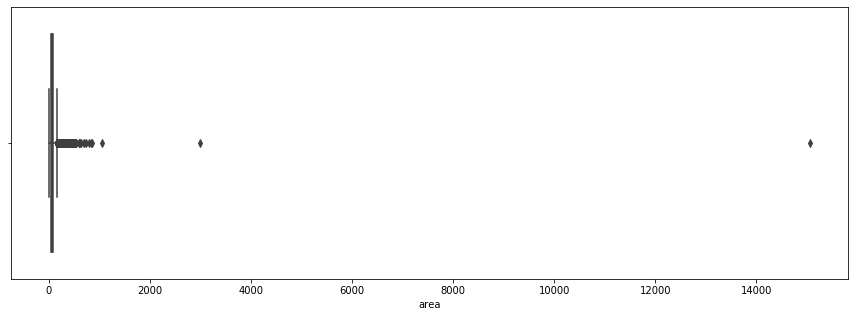

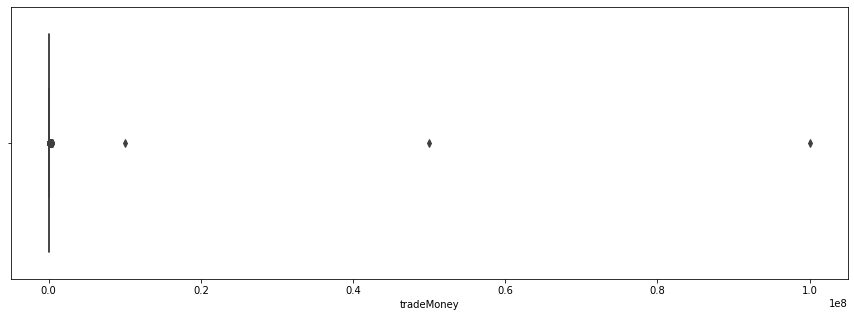

In [9]:
plt.figure(figsize=(15,5))
sns.boxplot(data_train.area)
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data_train.tradeMoney),
plt.show()

In [10]:
# 使用异常森林来处理
def IF_drop(train):
    IForest = IsolationForest(contamination=0.01)
    IForest.fit(train['tradeMoney'].values.reshape(-1,1))
    y_pred = IForest.predict(train['tradeMoney'].values.reshape(-1,1))
    drop_index = train.loc[y_pred == -1].index    
    print(drop_index)
    train.drop(drop_index, inplace = True)
    
    return train

data_train = IF_drop(data_train)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Int64Index([   62,    69,   128,   131,   246,   261,   266,   297,   308,
              313,
            ...
            39224, 39228, 39319, 39347, 39352, 39434, 39563, 41080, 41083,
            41233],
           dtype='int64', length=403)


In [11]:
def dropData(train):
    # 丢弃部分异常值
    train = train[train.area <= 200] #为啥超过200平就舍弃？因为测试集里最多才150
    train = train[(train.tradeMoney <=16000) & (train.tradeMoney >=700)]
    train.drop(train[train['totalFloor'] == 0].index, inplace = True )
    return train

data_train = dropData(data_train)
data_train

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,2,12,1,16,6,0,50,0,63,...,28248,614,111546,1124,284,0,2000.0,Train,11,28
1,125.55,2,28,0,14,6,2,129,1,48,...,14823,148,157552,701,22,1,2000.0,Train,12,16
2,132.00,2,28,1,32,6,0,178,1,49,...,77645,520,131744,57,20,1,16000.0,Train,12,22
3,57.00,2,4,0,17,6,3,312,1,50,...,8750,1665,253337,888,279,9,1600.0,Train,12,21
4,129.00,2,29,1,2,6,1,1256,2,43,...,800,117,125309,2038,480,0,2900.0,Train,11,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41435,10.00,0,39,2,11,3,3,1208,1,61,...,20904,0,245872,29635,2662,0,2190.0,Train,2,5
41436,7.10,0,24,0,6,3,3,852,1,54,...,4370,0,306857,28213,2446,0,2090.0,Train,1,22
41437,9.20,0,39,2,18,3,3,851,1,54,...,4370,0,306857,19231,2016,0,3190.0,Train,2,8
41438,14.10,0,39,1,8,3,3,790,1,54,...,4370,0,306857,17471,2554,0,2460.0,Train,3,22


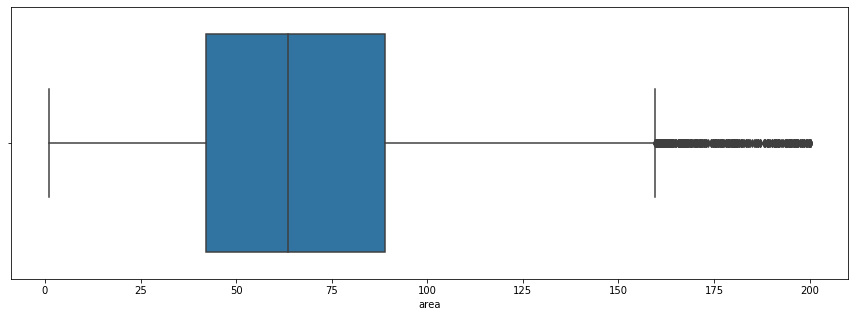

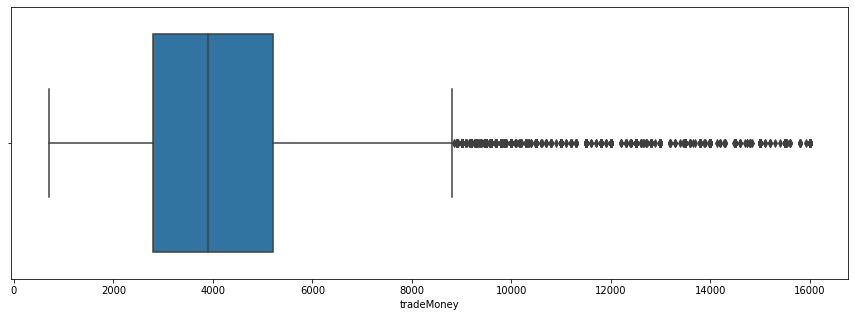

In [12]:
# 处理异常值后再次查看面积和租金分布图
plt.figure(figsize=(15,5))
sns.boxplot(data_train.area)
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data_train.tradeMoney),
plt.show()

## 深度清洗？

In [13]:
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

data_train = cleanData(data_train)

In [14]:
data_train

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,region,plate,...,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeMoney,Type,month,day
0,68.06,2,12,1,16,6,0,50,0,63,...,28248,614,111546,1124,284,0,2000.0,Train,11,28
1,125.55,2,28,0,14,6,2,129,1,48,...,14823,148,157552,701,22,1,2000.0,Train,12,16
2,132.00,2,28,1,32,6,0,178,1,49,...,77645,520,131744,57,20,1,16000.0,Train,12,22
3,57.00,2,4,0,17,6,3,312,1,50,...,8750,1665,253337,888,279,9,1600.0,Train,12,21
4,129.00,2,29,1,2,6,1,1256,2,43,...,800,117,125309,2038,480,0,2900.0,Train,11,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40210,10.00,0,39,2,11,3,3,1208,1,61,...,20904,0,245872,29635,2662,0,2190.0,Train,2,5
40211,7.10,0,24,0,6,3,3,852,1,54,...,4370,0,306857,28213,2446,0,2090.0,Train,1,22
40212,9.20,0,39,2,18,3,3,851,1,54,...,4370,0,306857,19231,2016,0,3190.0,Train,2,8
40213,14.10,0,39,1,8,3,3,790,1,54,...,4370,0,306857,17471,2554,0,2460.0,Train,3,22
